# 0.0 Imports

In [54]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle as pkl
import requests
from random import randint

import warnings
warnings.filterwarnings("ignore")

## 0.1 Datasets

In [3]:
features = pd.read_csv('../data/raw/features.csv')
stores = pd.read_csv('../data/raw/stores.csv')
train = pd.read_csv('../data/raw/train.csv')

# 1.0 Data Description

## 1.1 Looking Datasets

In [4]:
features.head()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False

In [5]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [6]:
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

## 1.2 Data Dimension

In [7]:
train.shape

(421570, 5)

In [8]:
stores.shape

(45, 3)

In [9]:
features.shape

(8190, 12)

## 1.3 Change Column Names

In [10]:
temp = []
for i in features.columns:
    temp.append(i.lower())
features.columns = temp

In [11]:
temp = []
for i in stores.columns:
    temp.append(i.lower())
stores.columns = temp

In [12]:
temp = []
for i in train.columns:
    temp.append(i.lower())
train.columns = temp

## 1.4 Merging Data

In [13]:
df = train.merge(features.drop('isholiday', axis=1), on=['store', 'date'], how='left')

df = df.merge(stores, on='store', how='left')

In [14]:
df.head()

store  dept        date  weekly_sales  isholiday  temperature  fuel_price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   markdown1  markdown2  markdown3  markdown4  markdown5         cpi  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   unemployment type    size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

## 1.5 Check Na

In [15]:
df.isna().sum() / df.shape[0] 

store           0.000000
dept            0.000000
date            0.000000
weekly_sales    0.000000
isholiday       0.000000
temperature     0.000000
fuel_price      0.000000
markdown1       0.642572
markdown2       0.736110
markdown3       0.674808
markdown4       0.679847
markdown5       0.640790
cpi             0.000000
unemployment    0.000000
type            0.000000
size            0.000000
dtype: float64

## 1.6 Removing Nas

In [16]:
df.drop('markdown1 markdown2 markdown3 markdown4 markdown5'.split(), axis=1, inplace=True)

In [17]:
df_raw = df.copy()

In [18]:
df.head()

store  dept        date  weekly_sales  isholiday  temperature  fuel_price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

          cpi  unemployment type    size  
0  211.096358         8.106    A  151315  
1  211.242170         8.106    A  151315  
2  211.289143         8.106    A  151315  
3  211.319643         8.106    A  151315  
4  211.350143         8.106    A  151315

## 1.7 Datatypes

In [19]:
df.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
isholiday          bool
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

## 1.8 Changing Datatypes

In [20]:
df['date'] = pd.to_datetime(df['date'])

df['isholiday'] = df['isholiday'].astype(int)

In [21]:
df['type'].value_counts()

type
A    215478
B    163495
C     42597
Name: count, dtype: int64

In [22]:
df['type'] = df['type'].apply(lambda x: 0 if x == 'A' else (1 if x == 'B' else 2))

## 1.9 Changing Granularity

In [23]:
df = df.groupby(['store', 'date']).agg({'weekly_sales':'sum', 'isholiday':'first', 'temperature':'first', 'fuel_price':'first', 'cpi':'first', 'unemployment':'first', 'type':'first', 'size':'first'}).reset_index()
df_raw = df.groupby(['store', 'date']).agg({'weekly_sales':'sum', 'isholiday':'first', 'temperature':'first', 'fuel_price':'first', 'cpi':'first', 'unemployment':'first', 'type':'first', 'size':'first'}).reset_index()

## 1.10 Descriptive Statistical

In [24]:
def descp_stasts(df, col):
    a = df[col].mean()
    b = df[col].median()
    c = (df[col].mean() - df[col].median()) / df[col].mean()
    d = df[col].min()
    e = df[col].max()
    f = df[col].max() - df[col].min()
    g = df[col].std()
    h = df[col].std() / df[col].mean()
    i = df[col].skew()
    j = df[col].kurtosis()
    k = np.percentile(df[col], 25)
    l = np.percentile(df[col], 50)
    m = np.percentile(df[col], 75)

    temp = pd.DataFrame([a, b, c, d, e, f, g, h, i, j, k, l, m], index='mean median coef_desloc min max range std coef_disp skew kurtosis q1 q2 q3'.split(), columns=[col])
    temp = round(temp, 2)
    return temp

In [25]:
def plot_stats(df, col):
    plt.figure(figsize=(3, 2))
    plt.subplot(3, 1, 1)
    sns.kdeplot(data=df, x=col)
    sns.despine()
    plt.title('densityplot')
    plt.xlabel('')
    plt.ylabel('')

    plt.figure(figsize=(3, 3))
    plt.subplot(3, 1, 2)
    sns.boxplot(data=df, x=col)
    sns.despine()
    plt.title('boxplot')
    plt.xlabel('')
    plt.ylabel('')

    plt.figure(figsize=(3, 3))
    plt.subplot(3, 1, 3)
    sns.histplot(data=df, x=col)
    sns.despine()
    plt.title('histplot')
    plt.xlabel('')
    plt.ylabel('');

In [26]:
def plot_stats_stores(df, col):
    for i in range(1, 5):
        rand = randint(df['store'].min(), df['store'].max())
        temp = df.loc[df['store']==rand]
        print(f'Store {rand}')
        plt.subplot(5, 1, i)
        sns.kdeplot(data=temp, x=col)
        sns.despine()
        plt.xlabel('')
        plt.ylabel('')
        plt.show();

In [27]:
def plot_stats_stores_(df, col, xlimmin, xlimmax):
    for i in range(1, 5):
        rand = randint(df['store'].min(), df['store'].max())
        temp = df.loc[df['store']==rand]
        print(f'Store {rand}')
        plt.subplot(5, 1, i)
        sns.kdeplot(data=temp, x=col)
        sns.despine()
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(xlimmin, xlimmax)
        plt.show();

### 1.10.1 Numerical Attributes

#### cpi

In [28]:
temp = descp_stasts(df, 'cpi')
temp

cpi
mean         171.58
median       182.62
coef_desloc   -0.06
min          126.06
max          227.23
range        101.17
std           39.36
coef_disp      0.23
skew           0.06
kurtosis      -1.84
q1           131.74
q2           182.62
q3           212.74

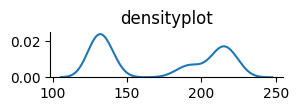

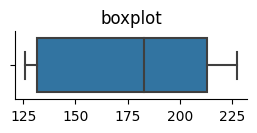

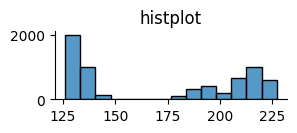

In [29]:
plot_stats(df, 'cpi')

In [30]:
cols = pd.DataFrame()
for i in range(1, 10):
    rand = randint(df['store'].min(), df['store'].max())
    temp = df.loc[df['store']==rand]
    temp_ = descp_stasts(temp, 'cpi')
    temp_.columns = [f'store {rand}']
    cols = pd.concat([cols, temp_], axis=1)
cols

store 31  store 7  store 6  store 6  store 17  store 43  store 8  \
mean           215.65   193.66   217.55   217.55    128.68    207.74   219.44   
median         215.11   192.90   217.01   217.01    129.08    207.26   218.89   
coef_desloc      0.00     0.00     0.00     0.00     -0.00      0.00     0.00   
min            210.00   189.38   211.84   211.84    126.06    202.37   213.67   
max            223.08   199.22   225.07   225.07    131.19    214.74   227.04   
range           13.08     9.84    13.23    13.23      5.13     12.37    13.37   
std              4.34     3.20     4.39     4.39      1.86      4.12     4.44   
coef_disp        0.02     0.02     0.02     0.02      0.01      0.02     0.02   
skew             0.27     0.16     0.27     0.27     -0.17      0.25     0.27   
kurtosis        -1.46    -1.48    -1.46    -1.46     -1.55     -1.47    -1.46   
q1             211.21   190.82   213.07   213.07    126.59    203.48   214.92   
q2             215.11   192.90   217.01   217.01    129.08    207.26   218.89   
q3             220.17   196.95   222.13   222.13    130.50    212.02   224.07   

             store 30  store 2  
mean           215.65   215.65  
median         215.11   215.11  
coef_desloc      0.00     0.00  
min            210.00   210.00  
max            223.08   223.08  
range           13.08    13.08  
std              4.34     4.34  
coef_disp        0.02     0.02  
skew             0.27     0.27  
kurtosis        -1.46    -1.46  
q1             211.21   211.21  
q2             215.11   215.11  
q3             220.17   220.17

Store 8


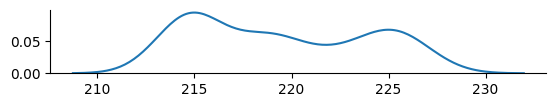

Store 21


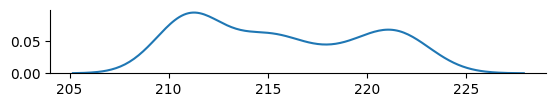

Store 40


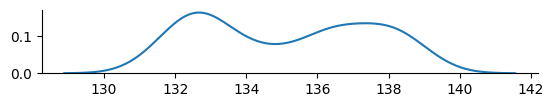

Store 42


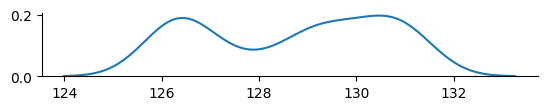

In [31]:
plot_stats_stores(df, 'cpi')

Store 24


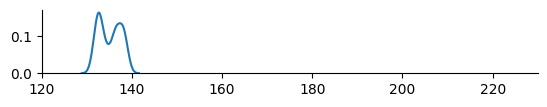

Store 24


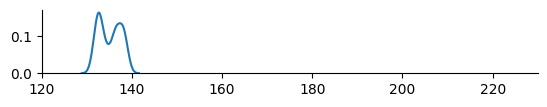

Store 35


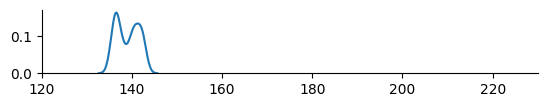

Store 9


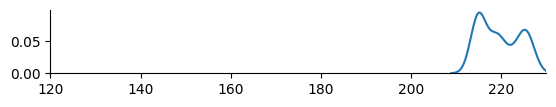

In [32]:
plot_stats_stores_(df, 'cpi', 120, 230)

#### temperature

In [33]:
temp = descp_stasts(df, 'temperature')
temp

temperature
mean               60.66
median             62.67
coef_desloc        -0.03
min                -2.06
max               100.14
range             102.20
std                18.44
coef_disp           0.30
skew               -0.34
kurtosis           -0.61
q1                 47.46
q2                 62.67
q3                 74.94

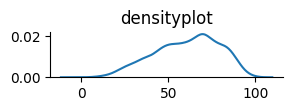

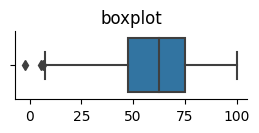

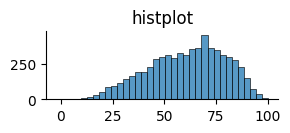

In [34]:
plot_stats(df, 'temperature')

In [35]:
cols = pd.DataFrame()
for i in range(1, 10):
    rand = randint(df['store'].min(), df['store'].max())
    temp = df.loc[df['store']==rand]
    temp_ = descp_stasts(temp, 'temperature')
    temp_.columns = [f'store {rand}']
    cols = pd.concat([cols, temp_], axis=1)
cols

store 3  store 27  store 42  store 5  store 2  store 19  \
mean           71.43     57.31     72.24    69.41    68.22     52.30   
median         73.01     58.38     73.56    70.96    69.21     53.44   
coef_desloc    -0.02     -0.02     -0.02    -0.02    -0.01     -0.02   
min            43.57     23.64     42.58    37.74    33.02     20.66   
max            89.12     82.69     95.36    91.07    93.34     79.37   
range          45.55     59.05     52.78    53.33    60.32     58.71   
std            12.65     16.02     14.03    14.23    15.49     16.61   
coef_disp       0.18      0.28      0.19     0.20     0.23      0.32   
skew           -0.48     -0.25     -0.25    -0.42    -0.32     -0.22   
kurtosis       -0.94     -1.12     -1.24    -0.88    -0.94     -1.15   
q1             61.61     45.18     59.06    58.66    56.74     39.06   
q2             73.01     58.38     73.56    70.96    69.21     53.44   
q3             82.64     71.73     85.11    81.20    81.94     67.99   

             store 18  store 1  store 33  
mean            53.37    68.31     76.73  
median          55.83    69.64     77.44  
coef_desloc     -0.05    -0.02     -0.01  
min             14.84    35.40     46.25  
max             79.75    91.65    100.14  
range           64.91    56.25     53.89  
std             16.70    14.25     15.38  
coef_disp        0.31     0.21      0.20  
skew            -0.30    -0.41     -0.15  
kurtosis        -1.08    -0.87     -1.33  
q1              39.61    58.26     61.99  
q2              55.83    69.64     77.44  
q3              68.76    80.48     91.47

Store 11


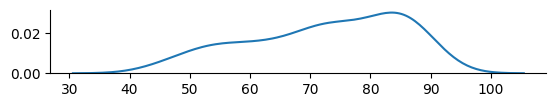

Store 20


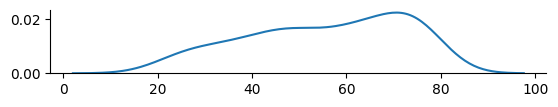

Store 12


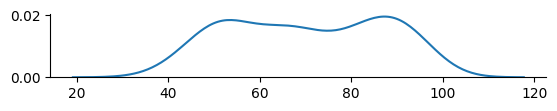

Store 28


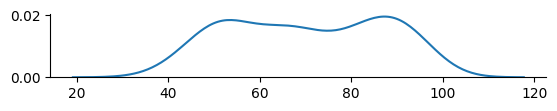

In [36]:
plot_stats_stores(df, 'temperature')

Store 39


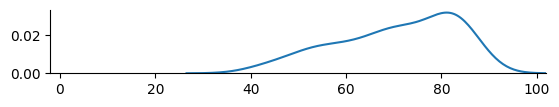

Store 9


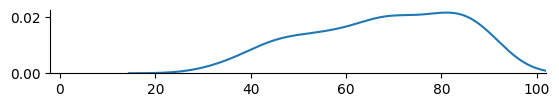

Store 44


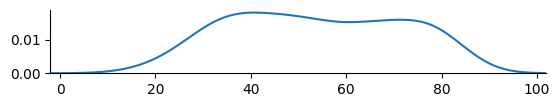

Store 32


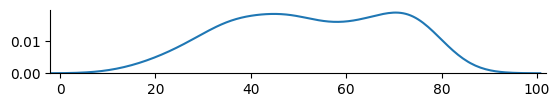

In [37]:
plot_stats_stores_(df, 'temperature', -2, 102)

# 2.0 Feature Engineering

In [38]:
df_raw.head()

store       date  weekly_sales  isholiday  temperature  fuel_price  \
0      1 2010-02-05    1643690.90          0        42.31       2.572   
1      1 2010-02-12    1641957.44          1        38.51       2.548   
2      1 2010-02-19    1611968.17          0        39.93       2.514   
3      1 2010-02-26    1409727.59          0        46.63       2.561   
4      1 2010-03-05    1554806.68          0        46.50       2.625   

          cpi  unemployment  type    size  
0  211.096358         8.106     0  151315  
1  211.242170         8.106     0  151315  
2  211.289143         8.106     0  151315  
3  211.319643         8.106     0  151315  
4  211.350143         8.106     0  151315

# 3.0 Data Preparation

## Target

In [39]:
# pp_weekly_sales = pp.MinMaxScaler()
# pp_weekly_sales = pp_weekly_sales.fit(df[['weekly_sales']].values)
# df['weekly_sales'] = pp_weekly_sales.transform(df[['weekly_sales']].values)

## Features

### Categorical Attributes

In [40]:
# # 'isholiday',
# map_isholiday = df.groupby('isholiday').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
# df['isholiday'] = df['isholiday'].map(map_isholiday)

# # 'type',
# map_type = df.groupby('type').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
# df['type'] = df['type'].map(map_type)

### Numerical Attributes

In [41]:
# # 'temperature',
# pp_temperature = pp.MinMaxScaler()
# pp_temperature = pp_temperature.fit(df[['temperature']].values)
# df['temperature'] = pp_temperature.transform(df[['temperature']].values)

# # 'fuel_price',
# pp_fuel_price = pp.MinMaxScaler()
# pp_fuel_price = pp_fuel_price.fit(df[['fuel_price']].values)
# df['fuel_price'] = pp_fuel_price.transform(df[['fuel_price']].values)

# # 'cpi',
# pp_cpi = pp.MinMaxScaler()
# pp_cpi = pp_cpi.fit(df[['cpi']].values)
# df['cpi'] = pp_cpi.transform(df[['cpi']].values)

# # 'unemployment',
# pp_unemployment = pp.MinMaxScaler()
# pp_unemployment = pp_unemployment.fit(df[['unemployment']].values)
# df['unemployment'] = pp_unemployment.transform(df[['unemployment']].values)

# # 'size']
# pp_size = pp.MinMaxScaler()
# pp_size = pp_size.fit(df[['size']].values)
# df['size'] = pp_size.transform(df[['size']].values)

## Splits

In [42]:
# train = df[df['date'] < df['date'].max() - pd.Timedelta(6, 'w')]
# test = df[df['date'] >= df['date'].max() - pd.Timedelta(6, 'w')]

In [43]:
# X_train = train.drop(['date', 'weekly_sales', 'store'], axis=1)
# y_train = train['weekly_sales']

# X_train_array = X_train.values
# y_train_array = np.array(y_train).reshape(-1, 1)

In [44]:
# X_test = test.drop(['date', 'weekly_sales', 'store'], axis=1)
# y_test = test['weekly_sales']

# X_test_array = X_test.values
# y_test_array = np.array(y_test).reshape(-1, 1)

# 4.0 ML Modeling

## Linear Regression

In [45]:
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, y_train)
predicts = lr_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_7954/478003382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_7954/478003382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_7954/478003382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

0.3951442206249105

## Random Forest

In [46]:
rf_model = RandomForestRegressor(max_depth=7)
rf_model = rf_model.fit(X_train, y_train)
predicts = rf_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_7954/1417689200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_7954/1417689200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_7954/1417689200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

0.15253689129944262

## XGBoost Regressor

In [47]:
xgb_model = XGBRegressor(max_depth=7)
xgb_model = xgb_model.fit(X_train, y_train)
predicts = xgb_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_7954/56048586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_7954/56048586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_7954/56048586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

0.13032780535369384

## XGBoost Regressor (kfold)

In [92]:
list_mae, list_mape = [], []
for i in range(1, 6):
    # Splits
    train = df[df['date'] < df['date'].max() - pd.Timedelta(6 * i, 'w')]
    valid = df[df['date'] >= df['date'].max() - pd.Timedelta(6 * i, 'w')]

    # Target
    pp_weekly_sales = pp.MinMaxScaler()
    pp_weekly_sales = pp_weekly_sales.fit(train[['weekly_sales']].values)
    train['weekly_sales'] = pp_weekly_sales.transform(train[['weekly_sales']].values)
    valid['weekly_sales'] = pp_weekly_sales.transform(valid[['weekly_sales']].values)

    # Features
    # Categorical Attributes
    # 'isholiday',
    map_isholiday = train.groupby('isholiday').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
    train['isholiday'] = train['isholiday'].map(map_isholiday)
    valid['isholiday'] = valid['isholiday'].map(map_isholiday)

    # 'type',
    map_type = train.groupby('type').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
    train['type'] = train['type'].map(map_type)
    valid['type'] = valid['type'].map(map_type)

    # Numerical Attributes
    # 'temperature',
    pp_temperature = pp.MinMaxScaler()
    pp_temperature = pp_temperature.fit(train[['temperature']].values)
    train['temperature'] = pp_temperature.transform(train[['temperature']].values)
    valid['temperature'] = pp_temperature.transform(valid[['temperature']].values)

    # 'fuel_price',
    pp_fuel_price = pp.MinMaxScaler()
    pp_fuel_price = pp_fuel_price.fit(train[['fuel_price']].values)
    train['fuel_price'] = pp_fuel_price.transform(train[['fuel_price']].values)
    valid['fuel_price'] = pp_fuel_price.transform(valid[['fuel_price']].values)

    # 'cpi',
    pp_cpi = pp.MinMaxScaler()
    pp_cpi = pp_cpi.fit(train[['cpi']].values)
    train['cpi'] = pp_cpi.transform(train[['cpi']].values)
    valid['cpi'] = pp_cpi.transform(valid[['cpi']].values)

    # 'unemployment',
    pp_unemployment = pp.MinMaxScaler()
    pp_unemployment = pp_unemployment.fit(train[['unemployment']].values)
    train['unemployment'] = pp_unemployment.transform(train[['unemployment']].values)
    valid['unemployment'] = pp_unemployment.transform(valid[['unemployment']].values)

    # 'size']
    pp_size = pp.MinMaxScaler()
    pp_size = pp_size.fit(train[['size']].values)
    train['size'] = pp_size.transform(train[['size']].values)
    valid['size'] = pp_size.transform(valid[['size']].values)

    # x, y splits
    X_train = train.drop(['date', 'weekly_sales', 'store'], axis=1)
    y_train = train['weekly_sales']

    X_train_array = X_train.values
    y_train_array = np.array(y_train).reshape(-1, 1)

    X_valid = valid.drop(['date', 'weekly_sales', 'store'], axis=1)
    y_valid = valid['weekly_sales']

    X_valid_array = X_valid.values
    y_valid_array = np.array(y_valid).reshape(-1, 1)

    # ml modeling
    # xgboosting
    xgb_model = XGBRegressor(max_depth=7)
    xgb_model = xgb_model.fit(X_train, y_train)
    predicts = xgb_model.predict(X_valid)

    valid['predicts'] = predicts
    valid['absolute_error'] = np.abs(valid['predicts'] - valid['weekly_sales'])
    list_mae.append(valid['absolute_error'].mean())
    valid['proportional_absolute_error'] = valid['absolute_error'] / valid['weekly_sales']
    list_mape.append(valid['proportional_absolute_error'].mean())

for i, j in enumerate(list_mape):
    print(f'Fold {i} has a error {round(j, 2)}')
print()
print(f'O erro médio do algorítimo é {round(np.mean(list_mape), 2)} com {round(np.std(list_mape), 2)} de desvio padrão')

Fold 0 has a error 0.13
Fold 1 has a error 0.12
Fold 2 has a error 0.19
Fold 3 has a error 0.17
Fold 4 has a error 0.17

O erro médio do algorítimo é 0.16 com 0.03 de desvio padrão


## Best model

In [33]:
model = xgb_model

# 5.0 Exports

In [34]:
pkl.dump(model, open('../src/models/model.pkl', 'wb'))

In [49]:
# pp_weekly_sales
pkl.dump(pp_weekly_sales, open('../src/features/pp_weekly_sales.pkl', 'wb'))
# map_isholiday
pkl.dump(map_isholiday, open('../src/features/map_isholiday.pkl', 'wb'))
# map_type
pkl.dump(map_type, open('../src/features/map_type.pkl', 'wb'))
# pp_temperature
pkl.dump(pp_temperature, open('../src/features/pp_temperature.pkl', 'wb'))
# pp_cpi
pkl.dump(pp_cpi, open('../src/features/pp_cpi.pkl', 'wb'))
# pp_fuel_price
pkl.dump(pp_fuel_price, open('../src/features/pp_fuel_price.pkl', 'wb'))
# pp_unemployment
pkl.dump(pp_unemployment, open('../src/features/pp_unemployment.pkl', 'wb'))
# pp_size
pkl.dump(pp_size, open('../src/features/pp_size.pkl', 'wb'))

# 6.0 API

## API Request

In [50]:
# data = X_train.sample(500).to_json(orient='records')
data = df_raw.to_json(orient='records', date_format='iso')
url = 'http://192.168.0.20:5000/predict'
header = {'Content-type':'application/json'}

df_request = requests.post(data=data, headers=header, url=url)
print(df_request.status_code)

df_request = pd.DataFrame(df_request.json(), columns=df_request.json()[0].keys())
df_request['date'] = pd.to_datetime(df_request['date'])
df_request.head()

200


store       date  weekly_sales  isholiday  temperature  fuel_price  \
0      1 2010-02-05    1643690.90          0        42.31       2.572   
1      1 2010-02-12    1641957.44          1        38.51       2.548   
2      1 2010-02-19    1611968.17          0        39.93       2.514   
3      1 2010-02-26    1409727.59          0        46.63       2.561   
4      1 2010-03-05    1554806.68          0        46.50       2.625   

          cpi  unemployment  type    size     predicts  
0  211.096358         8.106     0  151315  906266.1875  
1  211.242170         8.106     0  151315  883700.9375  
2  211.289143         8.106     0  151315  815290.5000  
3  211.319643         8.106     0  151315  703740.3125  
4  211.350143         8.106     0  151315  762490.0625

In [58]:
df_request['absolute_error'] =  np.abs(df_request['weekly_sales'] - df_request['predicts'])
mae = df_request['absolute_error'].mean()
df['percentage_absolute_error'] = df_request['absolute_error'] / df_request['weekly_sales']
mape = df['percentage_absolute_error'].mean()
mape

0.10128479129101794